In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, broadcast
import pandas as pd
import matplotlib.pyplot as plt
import time

# Initialize SparkSession only once
spark = SparkSession.builder \
    .appName("lvb-spark") \
    .config('spark.master', 'local') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.0') \
    .getOrCreate()

# Optimize shuffle partitions based on your machine's cores
spark.conf.set("spark.sql.shuffle.partitions", "8")  # Adjust as needed


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1cd62e07-d6fe-4b6c-b894-f10d7949268d;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 369ms :: artifacts dl 22ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       

In [2]:
# Load departures data from MongoDB
start_time = time.time()

df = spark.read.format("mongo") \
    .option("uri", "mongodb://mongo:27017/") \
    .option("database", "lvb") \
    .option("collection", "departures") \
    .load()

execution_duration = time.time() - start_time
print(f"Loaded departures data in {round(execution_duration, 2)} seconds")


Loaded departures data in 4.88 seconds


In [3]:
# Load stops data
start_time = time.time()

stops_df = spark.read.option("multiLine", "true").json("data/stops.json") \
    .select(explode("stops").alias("stop")) \
    .select(col("stop.id").alias("id"), col("stop.name").alias("name"))

execution_duration = time.time() - start_time
print(f"Loaded stops data in {round(execution_duration, 2)} seconds")


Loaded stops data in 1.57 seconds


In [4]:
# Calculate top 15 stop usage
start_time = time.time()

top_stop_usage = df.groupBy('stopId') \
    .count() \
    .orderBy(col('count').desc()) \
    .limit(15)  # Directly limit to top 15

top_stop_usage.cache()  # Cache the result for future use
top_stop_usage.show()

execution_duration = time.time() - start_time
print(f"Calculated top 15 stop usage in {round(execution_duration, 2)} seconds")

+-------+------+
| stopId| count|
+-------+------+
| 956291|481421|
| 955252|128600|
|8098205|100881|
| 956519| 92173|
| 953847| 91419|
|8012202| 87049|
| 956668| 80224|
|8010205| 68238|
| 955251| 65720|
| 956093| 65207|
| 957859| 63552|
| 955244| 61402|
| 957155| 53442|
| 958957| 52309|
| 964449| 50811|
+-------+------+

Calculated top 15 stop usage in 28.63 seconds


In [5]:
# Join top 15 stop usage with stop names using broadcast join
start_time = time.time()

top_stops_with_names = top_stop_usage.join(
    broadcast(stops_df),
    top_stop_usage.stopId == stops_df.id,
    "inner"
).select(
    top_stop_usage.stopId,
    "name",
    "count"
).orderBy(col("count").desc())

top_stops_with_names.cache() # cache the result for future use
top_stops_with_names.show(truncate=False)

execution_duration = time.time() - start_time
print(f"Joined top 15 stop usage with names in {round(execution_duration, 2)} seconds")


+-------+-------------------------------------------+------+
|stopId |name                                       |count |
+-------+-------------------------------------------+------+
|956291 |Hauptbahnhof (Tram/Bus), Leipzig           |481421|
|955252 |Wilhelm-Leuschner-Platz (Tram/Bus), Leipzig|128600|
|8098205|Leipzig Hbf (tief)                         |100881|
|956519 |Sportforum Süd, Leipzig                    |92173 |
|953847 |Waldplatz, Leipzig                         |91419 |
|8012202|Leipzig Wilhelm-Leuschner-Platz            |87049 |
|956668 |Roßplatz, Leipzig                          |80224 |
|8010205|Leipzig Hbf                                |68238 |
|955251 |Augustusplatz, Leipzig                     |65720 |
|956093 |Naunhofer Str., Leipzig                    |65207 |
|957859 |Goerdelerring, Leipzig                     |63552 |
|955244 |Paunsdorf Theodor-Heuss-Str., Leipzig      |61402 |
|957155 |Georg-Schumann-/Lindenthaler Str., Leipzig |53442 |
|958957 |Hauptbahnhof/We

In [6]:
# Collect top 15 and convert to Pandas
start_time = time.time()

stop_usage_pd = top_stops_with_names.toPandas()

execution_duration = time.time() - start_time
print(f"Converted top 15 to Pandas in {round(execution_duration, 2)} seconds")


Converted top 15 to Pandas in 0.48 seconds


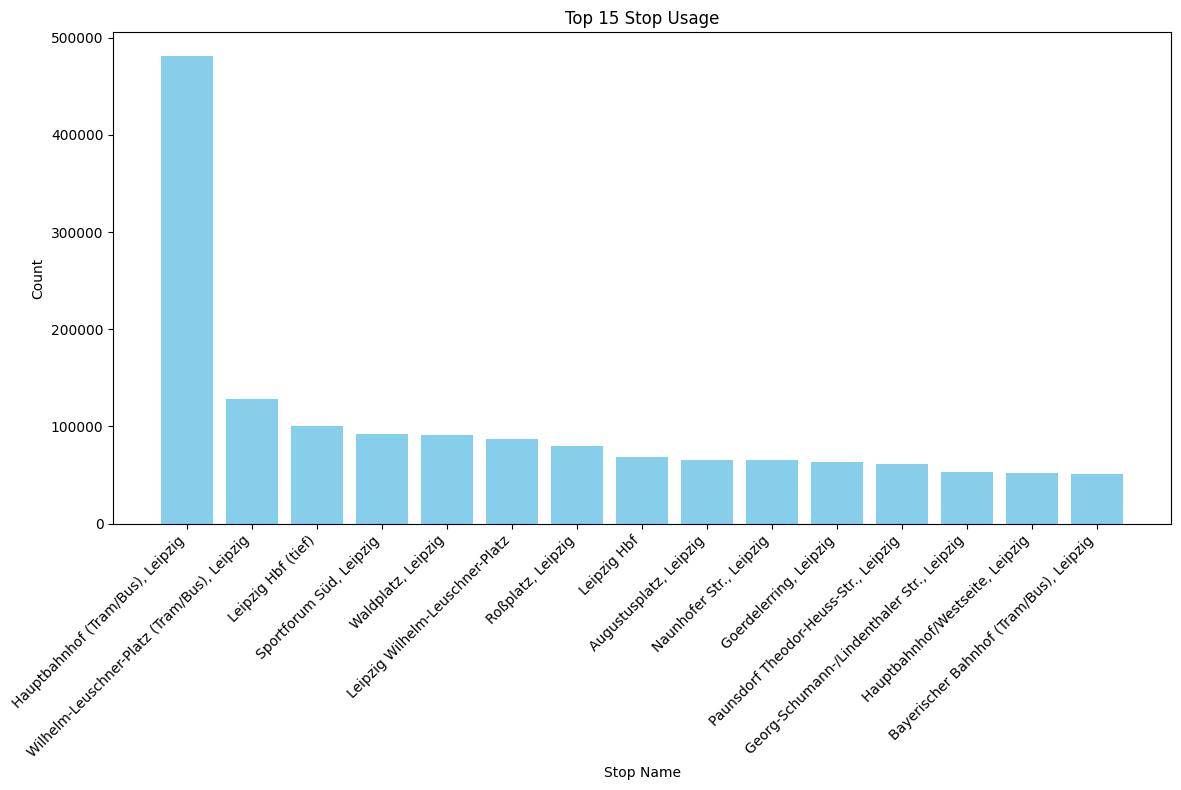

In [7]:
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(stop_usage_pd['name'], stop_usage_pd['count'], color='skyblue')
plt.title('Top 15 Stop Usage')
plt.xlabel('Stop Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
